#Library

In [17]:
import unicodedata
import regex as re
from pyvi import ViTokenizer, ViPosTagger

bang_nguyen_am= [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]

bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']
nguyen_am_to_ids = {}
for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

In [18]:
pip install transformers==4.30

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install vncorenlp

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# Data loader and pre-processing

In [4]:
import pandas as pd
# load data
train = pd.read_csv("train_augmented_dataset_label_1_2_num8_0.05_wordnet.csv", index_col=False)
dev = pd.read_csv("dev.csv", index_col=False)
test = pd.read_csv("test.csv", index_col=False)

train.reset_index(drop=True)

print(len(train))
print(len(dev))
print(len(test))

39750
2672
6680


In [5]:

from vncorenlp import VnCoreNLP
vncorenlp = VnCoreNLP("VnCoreNLP-master/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')


In [6]:
#pre-process
import re
import numpy as np
import  re
import string
STOPWORDS = 'vietnamese-stopwords.txt'
with open(STOPWORDS, "r", encoding="utf8") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)
#old
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
#new
def normalText(sent):
    sent = str(sent).replace('_',' ').replace('/',' trên ')
    sent = re.sub('-{2,}','',sent)
    sent = re.sub('\s+',' ', sent)
    patPrice = r'([0-9]+k?(\s?-\s?)[0-9]+\s?(k|K))|([0-9]+(.|,)?[0-9]+\s?(triệu|ngàn|trăm|k|K|))|([0-9]+(.[0-9]+)?Ä‘)|([0-9]+k)'
    patHagTag = r'#\s?[aăâbcdđeêghiklmnoôơpqrstuưvxyàằầbcdđèềghìklmnòồờpqrstùừvxỳáắấbcdđéếghíklmnóốớpqrstúứvxýảẳẩbcdđẻểghỉklmnỏổởpqrstủửvxỷạặậbcdđẹệghịklmnọộợpqrstụựvxỵãẵẫbcdđẽễghĩklmnõỗỡpqrstũữvxỹAĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXYÀẰẦBCDĐÈỀGHÌKLMNÒỒỜPQRSTÙỪVXỲÁẮẤBCDĐÉẾGHÍKLMNÓỐỚPQRSTÚỨVXÝẠẶẬBCDĐẸỆGHỊKLMNỌỘỢPQRSTỤỰVXỴẢẲẨBCDĐẺỂGHỈKLMNỎỔỞPQRSTỦỬVXỶÃẴẪBCDĐẼỄGHĨKLMNÕỖỠPQRSTŨỮVXỸ]+'
    patURL = r"(?:http://|www.)[^\"]+"
    sent = re.sub(patURL,'website',sent)
    sent = re.sub(patHagTag,' hagtag ',sent)
    sent = re.sub(patPrice, ' giá_tiền ', sent)
    sent = re.sub('\.+','.',sent)
    sent = re.sub('(hagtag\s+)+',' hagtag ',sent)
    sent = re.sub('\s+',' ',sent)
    return sent


def normalize_elonge_word(sent):
    s_new = ''
    for word in sent.split(' '):
        word_new = ' '
        for char in word.strip():
            if char != word_new[-1]:
                word_new += char
        s_new += word_new.strip() + ' '
    return s_new.strip()

def deleteIcon(text):
    text = text.lower()
    s = ''
    pattern = r"[a-zA-ZaăâbcdđeêghiklmnoôơpqrstuưvxyàằầbcdđèềghìklmnòồờpqrstùừvxỳáắấbcdđéếghíklmnóốớpqrstúứvxýảẳẩbcdđẻểghỉklmnỏổởpqrstủửvxỷạặậbcdđẹệghịklmnọộợpqrstụựvxỵãẵẫbcdđẽễghĩklmnõỗỡpqrstũữvxỹAĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXYÀẰẦBCDĐÈỀGHÌKLMNÒỒỜPQRSTÙỪVXỲÁẮẤBCDĐÉẾGHÍKLMNÓỐỚPQRSTÚỨVXÝẠẶẬBCDĐẸỆGHỊKLMNỌỘỢPQRSTỤỰVXỴẢẲẨBCDĐẺỂGHỈKLMNỎỔỞPQRSTỦỬVXỶÃẴẪBCDĐẼỄGHĨKLMNÕỖỠPQRSTŨỮVXỸ,._]"

    for char in text:
        if char !=' ':
            if len(re.findall(pattern, char)) != 0:
                s+=char
            elif char == '_':
                s+=char
        else:
            s+=char
    s = re.sub('\s+',' ',s)
    return s.strip()

def preprocess(text, tokenized=True, lowercased=True):
    #for punc in string.punctuation:
    #    text = text.replace(punc,' '+ punc + ' ')
    #text = normalText(text)
    #text = deleteIcon(text)
    # Lowercase
    #text = text.lower()
    # Removing multiple whitespaces
    #text = re.sub(r"\?", " \? ", text)
    # Remove numbers
    #text = re.sub(r"[0-9]+", " num ", text)
    # Split in tokens
    # Remove punctuation
    #for punc in string.punctuation:
    #  if punc not in "_":
    #      text = text.replace(punc,' ')
    #text = re.sub('\s+',' ',text)
    #text = normalize_elonge_word(text)
    #text = filter_stop_words(text, stopwords)
    #text = deEmojify(text)
    #text = filter_stop_words(text, stopwords)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text

    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

X_train = train['free_text']
y_train = train['label_id'].values

X_dev = dev['free_text']
y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

In [18]:
 print(X_train)

0        Em được làm fan cứng luôn rồi nè ❤️ reaction q...
1        Đúng là bọn mắt híp lò xo thụt :))) bên việt n...
2                 Đậu Văn Cường giờ giống thằng sida hơn à
3        CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...
4        Từ lý thuyết đến thực hành là cả 1 câu chuyện ...
                               ...                        
39745    Lũ " tài, vô dụng, học hành không lo, lo ăn ch...
39746    Lũ bất tài, vô dụng, học hành không lo, lo ăn ...
39747    Lũ bất tài, vô dụng, học hành không lo, lo ăn ...
39748    Lũ bất tài, vô dụng, học hành không lo, chăm l...
39749    Lũ bất tài, vô dụng, có trách nhiệm học hành k...
Name: free_text, Length: 39750, dtype: object


In [7]:
print(preprocess('Em được làm fan cứng luôn rồi nè',lowercased=False))

Em được làm fan cứng luôn rồi nè


# Model


## PhoBERT

In [8]:
# Set device and gpu
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [9]:
# PhoBERT
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)


C:\Users\thuon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 3).to(device)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)

C:\Users\thuon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NO

In [11]:

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=60)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=60)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=60)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='output/eda0.15',          
    num_train_epochs=3,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True,
    #learning_rate= 2e-5, 
    #gradient_accumulation_steps=5
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)
#callback = PrintClassificationReportCallback(test_dataset)
#trainer.add_callback(callback)
trainer.train()
trainer.save_model("output/eda0.05")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

C:\Users\thuon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

EDA 0.05 2 epoch

C:\Users\thuon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 15%|█▌        | 500/3244 [06:28<41:41,  1.10it/s]

{'loss': 0.6941, 'learning_rate': 5e-05, 'epoch': 0.31}


 31%|███       | 1000/3244 [14:34<37:48,  1.01s/it] 

{'loss': 0.554, 'learning_rate': 4.088921282798834e-05, 'epoch': 0.62}


 46%|████▌     | 1500/3244 [23:25<31:01,  1.07s/it]  

{'loss': 0.4915, 'learning_rate': 3.177842565597668e-05, 'epoch': 0.92}


 62%|██████▏   | 2000/3244 [32:41<22:23,  1.08s/it]

{'loss': 0.3958, 'learning_rate': 2.2667638483965014e-05, 'epoch': 1.23}


 77%|███████▋  | 2500/3244 [42:05<13:51,  1.12s/it]

{'loss': 0.3499, 'learning_rate': 1.3556851311953352e-05, 'epoch': 1.54}


 92%|█████████▏| 3000/3244 [51:30<04:29,  1.11s/it]

{'loss': 0.3385, 'learning_rate': 4.4460641399416915e-06, 'epoch': 1.85}


100%|██████████| 3244/3244 [56:05<00:00,  1.04s/it]


{'train_runtime': 3365.8204, 'train_samples_per_second': 30.828, 'train_steps_per_second': 0.964, 'train_loss': 0.4589581636553481, 'epoch': 2.0}


100%|██████████| 209/209 [01:26<00:00,  2.41it/s]


[[5202  160  186]
 [ 177  182   85]
 [ 207   78  403]]
F1 - micro: 0.8663173652694611
F1 - macro: 0.64916938629673


<Axes: >

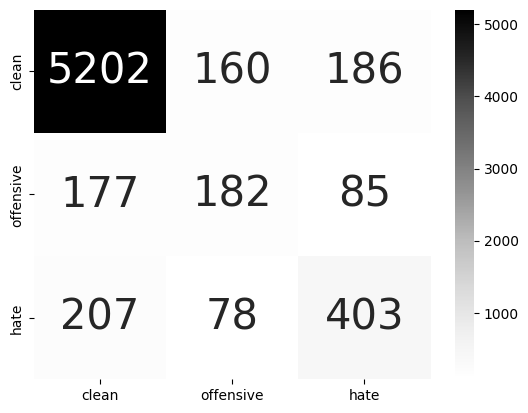

In [ ]:

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='output/bestbert0.1',          
    num_train_epochs=3,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True,
    learning_rate= 5e-5
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)
#callback = PrintClassificationReportCallback(test_dataset)
#trainer.add_callback(callback)
trainer.train()
trainer.save_model("output/bestbert0.1")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

Bert 0.1

 21%|██▏       | 592/2784 [14:02<51:57,  1.42s/it]
C:\Users\thuon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 18%|█▊        | 500/2784 [11:03<43:08,  1.13s/it]  

{'loss': 0.3145, 'learning_rate': 5e-05, 'epoch': 0.36}


 36%|███▌      | 1000/2784 [20:19<32:55,  1.11s/it] 

{'loss': 0.3668, 'learning_rate': 3.905429071803853e-05, 'epoch': 0.72}


 54%|█████▍    | 1500/2784 [29:24<21:20,  1.00it/s]  

{'loss': 0.3409, 'learning_rate': 2.810858143607706e-05, 'epoch': 1.08}


 72%|███████▏  | 2000/2784 [38:34<15:18,  1.17s/it]

{'loss': 0.2526, 'learning_rate': 1.7162872154115586e-05, 'epoch': 1.44}


 90%|████████▉ | 2500/2784 [48:09<05:18,  1.12s/it]

{'loss': 0.2432, 'learning_rate': 6.2171628721541155e-06, 'epoch': 1.8}


100%|██████████| 2784/2784 [53:50<00:00,  1.16s/it]


{'train_runtime': 3230.2116, 'train_samples_per_second': 27.569, 'train_steps_per_second': 0.862, 'train_loss': 0.29724398974714605, 'epoch': 2.0}


100%|██████████| 209/209 [01:28<00:00,  2.36it/s]


[[5321  104  123]
 [ 199  170   75]
 [ 230   65  393]]
F1 - micro: 0.8808383233532934
F1 - macro: 0.663568856048573


<Axes: >

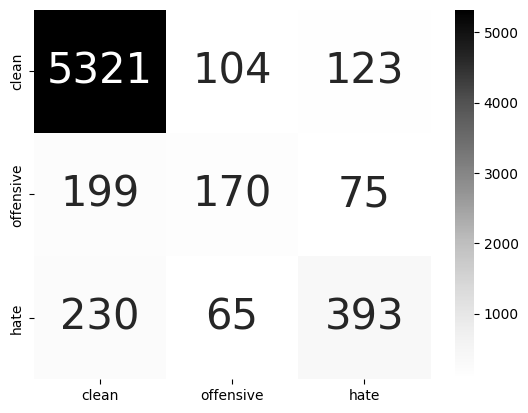

In [ ]:

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='output/Bert_aug_0.1',          
    num_train_epochs=2,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)
#callback = PrintClassificationReportCallback(test_dataset)
#trainer.add_callback(callback)
trainer.train()
trainer.save_model("output/best_Bert_aug_0.1")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

Best_dataset

C:\Users\thuon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 10%|█         | 500/4866 [07:48<1:32:18,  1.27s/it]

{'loss': 0.6888, 'learning_rate': 5e-05, 'epoch': 0.31}


 21%|██        | 1000/4866 [19:00<1:27:32,  1.36s/it]

{'loss': 0.5495, 'learning_rate': 4.427393495190106e-05, 'epoch': 0.62}


 31%|███       | 1500/4866 [30:08<1:08:51,  1.23s/it]

{'loss': 0.4874, 'learning_rate': 3.854786990380211e-05, 'epoch': 0.92}


 41%|████      | 2000/4866 [40:38<55:12,  1.16s/it]  

{'loss': 0.3933, 'learning_rate': 3.2821804855703165e-05, 'epoch': 1.23}


 51%|█████▏    | 2500/4866 [50:43<45:52,  1.16s/it]  

{'loss': 0.3508, 'learning_rate': 2.7095739807604216e-05, 'epoch': 1.54}


 62%|██████▏   | 3000/4866 [1:00:32<37:26,  1.20s/it]

{'loss': 0.3418, 'learning_rate': 2.1369674759505267e-05, 'epoch': 1.85}


 72%|███████▏  | 3500/4866 [1:10:04<24:41,  1.08s/it]  

{'loss': 0.2628, 'learning_rate': 1.5643609711406325e-05, 'epoch': 2.16}


 82%|████████▏ | 4000/4866 [1:19:17<15:33,  1.08s/it]

{'loss': 0.2056, 'learning_rate': 9.917544663307376e-06, 'epoch': 2.47}


 92%|█████████▏| 4500/4866 [1:28:13<06:30,  1.07s/it]

{'loss': 0.1946, 'learning_rate': 4.191479615208429e-06, 'epoch': 2.77}


100%|██████████| 4866/4866 [1:34:39<00:00,  1.17s/it]


{'train_runtime': 5679.6388, 'train_samples_per_second': 27.403, 'train_steps_per_second': 0.857, 'train_loss': 0.370967778755812, 'epoch': 3.0}


100%|██████████| 209/209 [01:22<00:00,  2.55it/s]


[[5205  176  167]
 [ 183  182   79]
 [ 215   83  390]]
F1 - micro: 0.8648203592814371
F1 - macro: 0.6446572875883132


<Axes: >

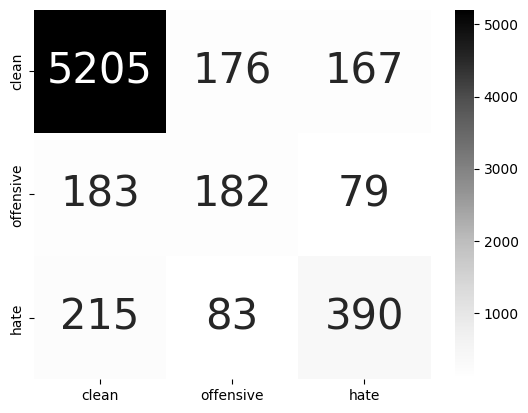

In [ ]:

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='output\Bert_aug_0.3',          
    num_train_epochs=2,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)
#callback = PrintClassificationReportCallback(test_dataset)
#trainer.add_callback(callback)
trainer.train()
trainer.save_model("output\Bert_aug_0.3")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

Bert_ 0.3_vncorenlp_best

  1%|          | 36/4182 [46:59<90:12:02, 78.32s/it]
C:\Users\thuon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 12%|█▏        | 500/4182 [06:22<56:37,  1.08it/s]

{'loss': 0.5546, 'learning_rate': 5e-05, 'epoch': 0.36}


 24%|██▍       | 1000/4182 [14:38<1:00:39,  1.14s/it]

{'loss': 0.4104, 'learning_rate': 4.3210211841390554e-05, 'epoch': 0.72}


 36%|███▌      | 1500/4182 [23:52<50:43,  1.13s/it]  

{'loss': 0.3777, 'learning_rate': 3.64204236827811e-05, 'epoch': 1.08}


 48%|████▊     | 2000/4182 [33:28<42:36,  1.17s/it]  

{'loss': 0.3108, 'learning_rate': 2.9630635524171645e-05, 'epoch': 1.43}


 60%|█████▉    | 2500/4182 [43:00<31:13,  1.11s/it]  

{'loss': 0.3062, 'learning_rate': 2.2840847365562197e-05, 'epoch': 1.79}


 72%|███████▏  | 3000/4182 [52:33<22:11,  1.13s/it]

{'loss': 0.2566, 'learning_rate': 1.6051059206952742e-05, 'epoch': 2.15}


 84%|████████▎ | 3500/4182 [1:02:04<13:11,  1.16s/it]

{'loss': 0.2042, 'learning_rate': 9.261271048343292e-06, 'epoch': 2.51}


 96%|█████████▌| 4000/4182 [1:11:36<03:25,  1.13s/it]

{'loss': 0.2065, 'learning_rate': 2.4714828897338406e-06, 'epoch': 2.87}


100%|██████████| 4182/4182 [1:15:06<00:00,  1.08s/it]


{'train_runtime': 4506.1367, 'train_samples_per_second': 29.69, 'train_steps_per_second': 0.928, 'train_loss': 0.3225921017880761, 'epoch': 3.0}


100%|██████████| 209/209 [01:25<00:00,  2.44it/s]


[[5294  124  130]
 [ 194  166   84]
 [ 234   73  381]]
F1 - micro: 0.8744011976047904
F1 - macro: 0.6482687020078252


<Axes: >

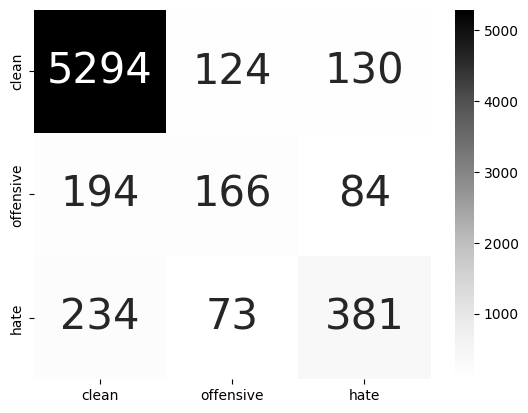

In [ ]:

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='output\Bert_aug_0.3',          
    num_train_epochs=3,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)
#callback = PrintClassificationReportCallback(test_dataset)
#trainer.add_callback(callback)
trainer.train()
trainer.save_model("output\Bert_aug_0.3")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

Bert 0.4 best

C:\Users\thuon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 12%|█▏        | 500/4191 [06:20<53:53,  1.14it/s]

{'loss': 0.5587, 'learning_rate': 5e-05, 'epoch': 0.36}


 24%|██▍       | 1000/4191 [14:03<50:32,  1.05it/s] 

{'loss': 0.4278, 'learning_rate': 4.322676781360065e-05, 'epoch': 0.72}


 36%|███▌      | 1500/4191 [22:11<44:33,  1.01it/s]  

{'loss': 0.3789, 'learning_rate': 3.64535356272013e-05, 'epoch': 1.07}


 48%|████▊     | 2000/4191 [30:29<36:48,  1.01s/it]  

{'loss': 0.322, 'learning_rate': 2.9680303440801956e-05, 'epoch': 1.43}


 60%|█████▉    | 2500/4191 [38:53<27:48,  1.01it/s]  

{'loss': 0.3139, 'learning_rate': 2.2907071254402602e-05, 'epoch': 1.79}


 72%|███████▏  | 3000/4191 [47:21<19:55,  1.00s/it]

{'loss': 0.281, 'learning_rate': 1.6133839068003252e-05, 'epoch': 2.15}


 84%|████████▎ | 3500/4191 [55:55<11:52,  1.03s/it]

{'loss': 0.2266, 'learning_rate': 9.360606881603902e-06, 'epoch': 2.51}


 95%|█████████▌| 4000/4191 [1:04:25<03:18,  1.04s/it]

{'loss': 0.2076, 'learning_rate': 2.5873746952045515e-06, 'epoch': 2.86}


100%|██████████| 4191/4191 [1:07:40<00:00,  1.03it/s]


{'train_runtime': 4060.9813, 'train_samples_per_second': 33.003, 'train_steps_per_second': 1.032, 'train_loss': 0.3338532508116467, 'epoch': 3.0}


100%|██████████| 209/209 [01:20<00:00,  2.59it/s]


[[5273  148  127]
 [ 192  185   67]
 [ 214   75  399]]
F1 - micro: 0.8767964071856288
F1 - macro: 0.6655219254128414


<Axes: >

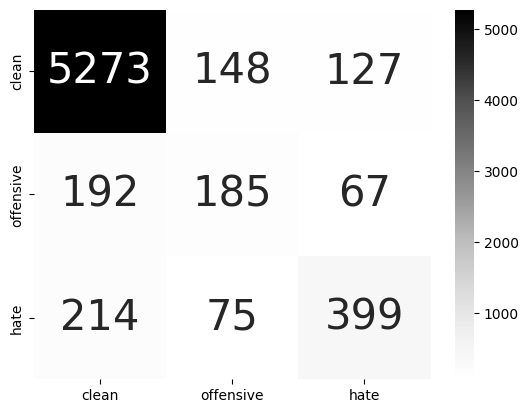

In [ ]:

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='output\Bert_aug_0.4',          
    num_train_epochs=3,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)
#callback = PrintClassificationReportCallback(test_dataset)
#trainer.add_callback(callback)
trainer.train()
trainer.save_model("output\Bert_aug_0.4")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

bert_0.2_best

100%|██████████| 209/209 [01:01<00:00,  3.41it/s]

[[5266  136  146]
 [ 188  177   79]
 [ 210   64  414]]
F1 - micro: 0.8767964071856288
F1 - macro: 0.6648320032865872
Accuracy: 0.8767964071856288
Recall: 0.649854569027202


<Axes: >

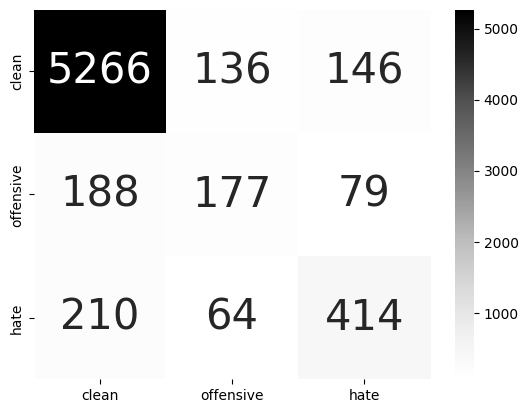

In [ ]:
y_pred_classify = trainer.predict(test_dataset)
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Tính toán accuracy và recall
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
print("Accuracy:", accuracy)
print("Recall:", recall)
# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

PhoBERT-BASE dataset

[[5257  111  180]
 [ 186  157  101]
 [ 220   67  401]]
F1 - micro: 0.8705089820359282
F1 - macro: 0.6421037502649815
Accuracy: 0.8705089820359282
Recall: 0.6280003689996396


<Axes: >

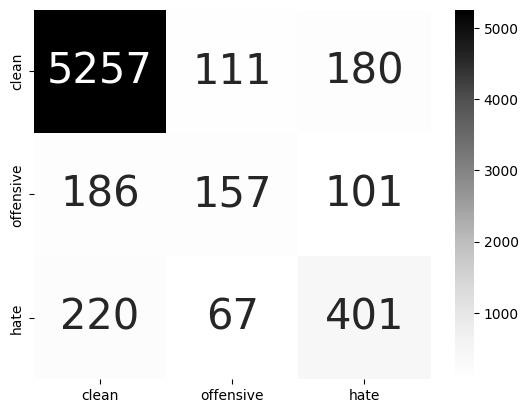

In [ ]:
cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Tính toán accuracy và recall
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
print("Accuracy:", accuracy)
print("Recall:", recall)
# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})